In [4]:
import intake
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.dates import date2num
from scipy import interpolate, stats, ndimage
from scipy.stats import ttest_ind, chi2_contingency
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import eurec4a
cat_eurec4a = eurec4a.get_intake_catalog()

this code aims to estimate the typical moisture that is advected by a typical updraft, and compare it to en estimation of the detrained air from a cloud:

## Load data

In [5]:
def load_and_concatenate_xarrays(dir1, dir2, pattern='*.nc'):
    """
    Load and concatenate xarray datasets from two directories along the time dimension.

    Parameters:
    - dir1 (str): The first directory path.
    - dir2 (str): The second directory path.
    - pattern (str): File pattern to match, default is '*.nc' for netCDF files.

    Returns:
    - xr.Dataset: A single xarray dataset concatenated along the time dimension.
    """
    # Get all file paths matching the pattern in both directories
    files_dir1 = sorted([os.path.join(dir1, f) for f in os.listdir(dir1) if f.endswith('.nc')])
    files_dir2 = sorted([os.path.join(dir2, f) for f in os.listdir(dir2) if f.endswith('.nc')])
    
    # Combine file lists
    all_files = files_dir1 + files_dir2
    
    # Open and concatenate all files along the time dimension
    ds_combined = xr.open_mfdataset(all_files, combine='nested', concat_dim='time', parallel=True)
    
    return ds_combined

In [7]:
dir1 = '/pool/data/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/L_Vertical_velocity/WBAND_LIDAR/202001/'
dir2 = '/pool/data/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/L_Vertical_velocity/WBAND_LIDAR/202002/'

# we get the vertical velocities from the directory with the data
w_band_doppler = load_and_concatenate_xarrays(dir1, dir2)

## Find the typical vertical wind velocity

In [8]:
#
start_time = np.datetime64('2020-01-12T00:30:00')
end_time   = np.datetime64('2020-12-29T23:59:00')

# Ensure time index is sorted in ascending order
if not np.all(w_band_doppler.time.values[1:] > w_band_doppler.time.values[:-1]):
    w_band_doppler = w_band_doppler.sortby('time')

w_doppler_selected = w_band_doppler.sel(time=slice(start_time, end_time))
w_doppler = w_doppler_selected.dv_corr

In [5]:
clouds = np.loadtxt('./data/processed_data/cloud_borders_2020.txt', delimiter=',', dtype='object')
clouds[:, 0] = np.array(clouds[:, 0], dtype='datetime64[s]')
clouds[:, 1] = np.array(clouds[:, 1], dtype='datetime64[s]')
clouds[:, 2] = np.array(clouds[:, 2], dtype='float64')
clouds[:, 3] = np.array(clouds[:, 3], dtype='float64')
clouds[:, 4] = np.array(clouds[:, 4], dtype='float64')
clouds[:, 5] = np.array(clouds[:, 5], dtype='float64')
clouds_time = clouds[(clouds[:, 0] >= start_time) & (clouds[:, 0] <= end_time)]
clouds_shallow = clouds_time[(clouds_time[:,2] >= 40) & (clouds_time[:,3] <= 1500) & (clouds_time[:,2] <= 1000) & ((clouds_time[:,4] - clouds_time[:,3]) >= 100) & ((clouds_time[:,4] - clouds_time[:,3]) <= 700)]

In [6]:
def composite_w(w, clouds, altitude_min, altitude_max):
    #w should be a time serie f the vertical wind
    #clouds is an array of the clouds that I take in consideration
    delta_time = np.timedelta64(20, 'm')
    clouds = clouds[(clouds[:, 3] >= altitude_min) & (clouds[:, 3] <= altitude_max)]
    clouds = clouds[(clouds[:, 2] >= 200)]
    w_cloud_list = []
    
    for cloud, cloud_times in enumerate(clouds):
        cloud_base = cloud_times[3]
        start_time = np.datetime64(cloud_times[0])
        end_time = np.datetime64(cloud_times[1])
        
        
        w_cloud = w.sel(time = slice(start_time, end_time)).sel(range = slice(cloud_base-200,cloud_base))
        
        
        w_cloud['range'] = (w_cloud.range - w_cloud.range.max())
        
        try: 
            scaled_time = (w_cloud.time - w_cloud.time.min()) / (w_cloud.time.max() - w_cloud.time.min())
            #print(type(scaled_time.values[0]))
            # Interpolate the data onto the scaled time axis
            
            w_cloud['time'] = scaled_time
            new_time = np.linspace(0,1,100)
            w_cloud_interp = w_cloud.interp(time=new_time)
            
            w_cloud_list.append(w_cloud_interp)
            
        except:
            continue
    w_cloud_concat = xr.concat(w_cloud_list, dim='cloud')
        
    return w_cloud_concat

In [7]:
altitude_min = 600
altitude_max = 1000
w_composite = composite_w(w_doppler, clouds_time, altitude_min, altitude_max).load()

In [8]:
def plot_hist_quantile(xarray, bins):
    xarray_flat = xarray.values.flatten()

    # Remove NaN values for histogram and percentile calculation
    xarray_flat = xarray_flat[~np.isnan(xarray_flat)]

    plt.figure(figsize=(5,5))
    # Plot the histogram
    hist_data = plt.hist(xarray_flat, bins=bins, edgecolor='black')
    #plt.show()

    # Calculate the 90th percentile
    percentile_90 = np.percentile(xarray_flat, 90)

    # Calculate the mean of values greater than or equal to the 90th percentile
    mean_90th_percentile = np.mean(xarray_flat[xarray_flat >= percentile_90])

    print("Mean value of the top 10% values (90th percentile and above):", mean_90th_percentile)

    return mean_90th_percentile, hist_data

Mean value of the top 10% values (90th percentile and above): 2.8818784111923677


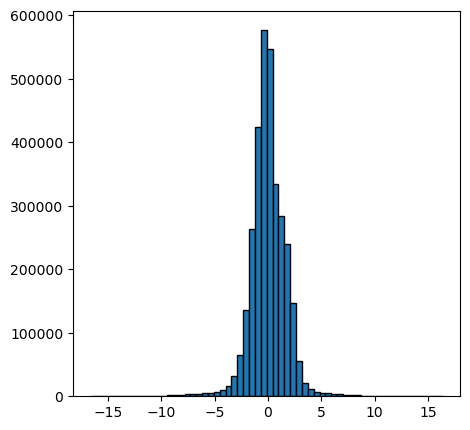

In [9]:
quantile_w, hist_data_w = plot_hist_quantile(w_composite, bins = 60)

## Repeat the same for specific humidity

In [10]:
ds_met = cat_eurec4a.barbados.bco.meteorology.to_dask().sel(time=slice(start_time, end_time))

In [11]:
def specific_humidity(temperature, pressure, relative_humidity):
    
    # Calculate the saturation vapor pressure (es) in hPa
    es = 6.1078 * np.exp((17.27 * temperature) / (temperature + 237.29))
    
    # Calculate the actual vapor pressure (e) in hPa, or partial water vapour pressure
    e = relative_humidity * es / 100 #/100 to have the RH between 0 and 1 
    
    # Calculate the specific humidity (q)
    q = 0.622 * e / (pressure - (0.378 * e)) #in kg/kg
    
    return q

In [12]:
q_BCO = specific_humidity(ds_met.T, ds_met.P, ds_met.RH)

Mean value of the top 10% values (90th percentile and above): 16.586374


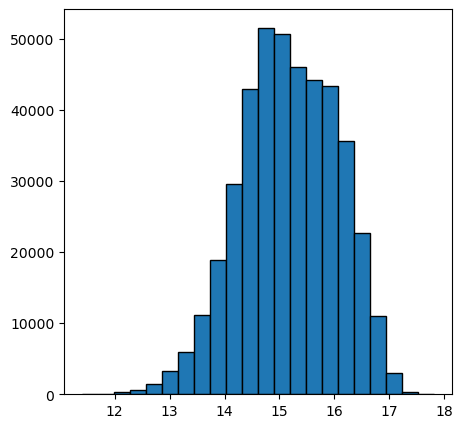

In [13]:
quantile_q, hist_data_q = plot_hist_quantile(q_BCO*1000, bins = 22)

# Estimate typical updraft and detrained mass

Using the mean area of clouds and their depth, we first compute the typical moisture mass flux that is advected

In [14]:
def get_mean_area_clouds(clouds, altitude_min, altitude_max):
    #returns the mean area in square meter of clouds

    mean_length = np.mean(clouds[:,2])
    
    mean_surface = np.pi*(mean_length/2)**2
    
    return mean_surface, mean_length

In [15]:
def return_mass_flux(w,q,A,t):
    """
    This takes as input the vertical velocitiy (in m.s-1), 
    the specific humidity (in kg/kg), 
    the typical area of a cloud in (m^2)
    and the typical lifetime of a cloud (in hours)
    """
    t_sec = t*3600
    rho_0 = 1.225 #kg/m^3 air density at sea level
    density = rho_0 * np.exp(-800/(8.5*1000)) #8.5km is the scale height of the atmosphere, i.e., vertical distance over which the pressure decreases by a factor of e
    mass_flux = w * q * A * t_sec * density
    print(f"{mass_flux:.2e} kg")
    return mass_flux

In [16]:
get_mean_area_clouds(clouds_shallow, altitude_min, altitude_max)

(203700.53982095994, 509.2735832378761)

In [17]:
moisture_mass_flux = return_mass_flux(quantile_w,quantile_q,get_mean_area_clouds(clouds_shallow, altitude_min, altitude_max)[0],1)

3.91e+10 kg


Now we can compute the total humidity of the envelope, to estimate how much would have to be detrained to form the observed envelopes

In [31]:
radius_envelope = 9000 #take a lower bound to be sure
Vol_envelope_cloud = np.pi* (radius_envelope + get_mean_area_clouds(clouds_shallow, altitude_min, altitude_max)[1]/2)**2*(clouds_shallow[:,4] - clouds_shallow[:,3]).mean()
#Vol_envelope = Vol_envelope_cloud - get_mean_area_clouds(clouds_time, altitude_min, altitude_max)[0]* get_mean_area_clouds(clouds_time, altitude_min, altitude_max)[1]

rho_0 = 1.225 #kg/m^3 air density at sea level
density = rho_0 * np.exp(-800/(8.5*1000)) #8.5km is the scale height of the atmosphere, i.e., vertical distance over which the pressure decreases by a factor of e

distances = np.arange(0, radius_envelope, 100)
quantile_q_profile = quantile_q #* (distances / radius_envelope) #assume that it decreases with 1/distance

total_moisture = Vol_envelope_cloud * np.mean(quantile_q_profile) * density
f"{total_moisture:.2e} kg"

'1.10e+12 kg'

In [32]:
f"factor between the ratio of envelope moisture and moisture for shallow clouds from the mass flux is {total_moisture/moisture_mass_flux:.2e}"

'factor between the ratio of envelope moisture and moisture for shallow clouds from the mass flux is 2.81e+01'